## Libraries

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib

import os,sys,h5py,json,re

## Parameters

In [2]:
vocab_size           = 5000
hide_most_frequently = 0

review_len           = 256
dense_vector_size    = 32

epochs               = 30
batch_size           = 512

fit_verbosity        = 1

## Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words=vocab_size, skip_top=hide_most_frequently, seed= 42,)

y_train = np.asarray(y_train).astype('float32')
y_test  = np.asarray(y_test ).astype('float32')

# ---- About
print("x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

x_train : (25000,)  y_train : (25000,)
x_test  : (25000,)  y_test  : (25000,)


In [4]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#      Shift the dictionary from +3
#      Add <pad>, <start> and <unknown> tags
#      Create a reverse dictionary : {index:word}
#
word_index = imdb.get_word_index()
word_index = {w:(i+3) for w,i in word_index.items()}
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2, '<undef>':3,} )
index_word = {index:word for word,index in word_index.items()} 

# ---- A nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

In [5]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

print(x_train[12])

[   1   14   22 1367   53  206  159    4  636  898   74   26   11  436
  363  108    7   14  432   14   22    9 1055   34    2    2    5  381
 3705 4509   14  768   47  839   25  111 1517 2579 1991  438 2663  587
    4  280  725    6   58   11 2714  201    4  206   16  702    5    2
   19  480    2  157   13   64  219    4    2   11  107  665 1212   39
    4  206    4   65  410   16  565    5   24   43  343   17    2    8
  169  101   85  206  108    8 3008   14   25  215  168   18    6 2579
 1991  438    2   11  129 1609   36   26   66  290 3303   46    5  633
  115 4363    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [6]:
output_dir           = 'Text'

with h5py.File(f'{output_dir}/dataset_imdb.h5', 'w') as f:
    f.create_dataset("x_train",    data=x_train)
    f.create_dataset("y_train",    data=y_train)
    f.create_dataset("x_test",     data=x_test)
    f.create_dataset("y_test",     data=y_test)

with open(f'{output_dir}/word_index.json', 'w') as fp:
    json.dump(word_index, fp)

with open(f'{output_dir}/index_word.json', 'w') as fp:
    json.dump(index_word, fp)

print('Saved.')

Saved.


## Model

In [7]:
def get_model(vocab_size=10000, dense_vector_size=32, review_len=256):
    
    model = keras.Sequential()
    model.add(keras.layers.Input( shape=(review_len,) ))
    model.add(keras.layers.Embedding(input_dim    = vocab_size, 
                                     output_dim   = dense_vector_size, 
                                     input_length = review_len))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(dense_vector_size, activation='relu'))
    model.add(keras.layers.Dense(1,                 activation='sigmoid'))

    model.compile(optimizer = 'adam',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

In [8]:
model = get_model(vocab_size, dense_vector_size, review_len)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 32)           160000    
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 161,089
Trainable params: 161,089
Non-trainable params: 0
_________________________________________________________________


In [9]:
os.makedirs(f'{output_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{output_dir}/models/best_model.h5'
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

In [10]:
history = model.fit(x_train,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [savemodel_callback])

Epoch 1/30
49/49 [==============================] - 2s 34ms/step - loss: 0.6881 - accuracy: 0.6170 - val_loss: 0.6786 - val_accuracy: 0.6967
Epoch 2/30
49/49 [==============================] - 2s 33ms/step - loss: 0.6526 - accuracy: 0.7310 - val_loss: 0.6192 - val_accuracy: 0.7580
Epoch 3/30
49/49 [==============================] - 2s 42ms/step - loss: 0.5663 - accuracy: 0.7914 - val_loss: 0.5218 - val_accuracy: 0.8059
Epoch 4/30
49/49 [==============================] - 2s 39ms/step - loss: 0.4602 - accuracy: 0.8363 - val_loss: 0.4282 - val_accuracy: 0.8409
Epoch 5/30
49/49 [==============================] - 2s 35ms/step - loss: 0.3795 - accuracy: 0.8650 - val_loss: 0.3729 - val_accuracy: 0.8558
Epoch 6/30
49/49 [==============================] - 2s 34ms/step - loss: 0.3298 - accuracy: 0.8777 - val_loss: 0.3395 - val_accuracy: 0.8654
Epoch 7/30
49/49 [==============================] - 2s 33ms/step - loss: 0.2972 - accuracy: 0.8880 - val_loss: 0.3204 - val_accuracy: 0.8695
Epoch 8/30
49

## Result and prediction

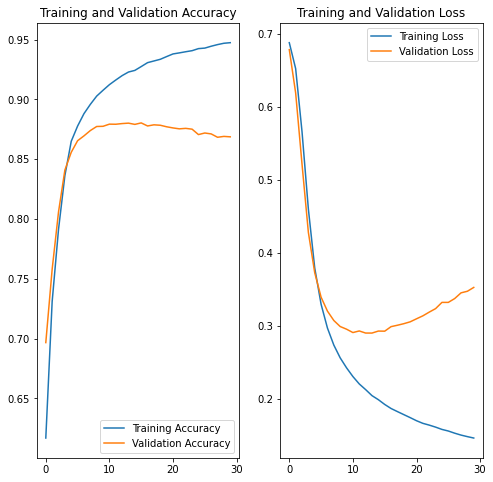

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
model = keras.models.load_model(f'{output_dir}/models/best_model.h5')

# ---- Evaluate
score  = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))



x_test / loss      : 0.2904
x_test / accuracy  : 0.8801


([<matplotlib.patches.Wedge at 0x1d2892860a0>,
 [Text(-0.7300087307652622, -0.82285311751642, 'Accuracy'),
  Text(0.7300087307652623, 0.8228531175164199, 'Errors')],
 [Text(-0.39818658041741567, -0.44882897319077447, '88.0%'),
  Text(0.3981865804174157, 0.4488289731907744, '12.0%')])

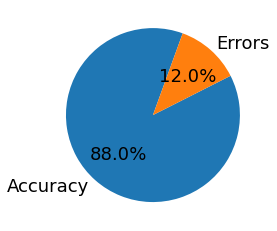

In [13]:
values=[score[1], 1-score[1]]
plt.pie(values, labels=["Accuracy", "Errors"], autopct='%1.1f%%', startangle=70, 
            textprops={'fontsize': 18})


782/782 [==============================] - 1s 1ms/step
tf.Tensor(
[[11136  1364]
 [ 1633 10867]], shape=(2, 2), dtype=int32)


<AxesSubplot:>

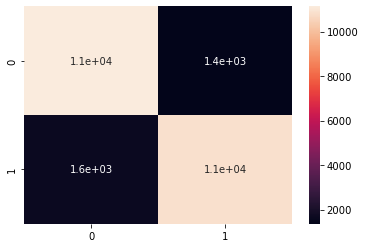

In [14]:
# ---- Confusion matrix
import seaborn as sns

y_sigmoid = model.predict(x_test)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

cf_matrix=tf.math.confusion_matrix(y_test, y_pred)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True)

In [15]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix( y_test, y_pred, normalize="true")
df=pd.DataFrame(cm)
print(df)

         0        1
0  0.89088  0.10912
1  0.13064  0.86936


In [16]:
vocab_size           = 10000
review_len           = 256

In [17]:
reviews = [ "This film is particularly nice, a must see.",
             "This film is a great classic that cannot be ignored.",
             "I don't remember ever having seen such a movie...",
             "This movie is just abominable and doesn't deserve to be seen!"]

In [18]:
with open(f'{output_dir}/word_index.json', 'r') as fp:
    word_index = json.load(fp)
    word_index = { w:int(i) for w,i in word_index.items() }
    print('Loaded. ', len(word_index), 'entries in word_index' )
    index_word = { i:w      for w,i in word_index.items() }
    print('Loaded. ', len(index_word), 'entries in index_word' )

Loaded.  88588 entries in word_index
Loaded.  88588 entries in index_word


In [19]:
nb_reviews = len(reviews)
x_data     = []

# ---- For all reviews
for review in reviews:
    print('Words are : ', end='')
    # ---- First index must be <start>
    index_review=[1]
    print('1 ', end='')
    # ---- For all words
    for w in review.split(' '):
        # ---- Clean it
        w_clean = re.sub(r"[^a-zA-Z0-9]", "", w)
        # ---- Not empty ?
        if len(w_clean)>0:
            # ---- Get the index
            w_index = word_index.get(w,2)
            if w_index>vocab_size : w_index=2
            # ---- Add the index if < vocab_size
            index_review.append(w_index)
            print(f'{w_index} ', end='')
    # ---- Add the indexed review
    x_data.append(index_review)
    print()

# ---- Padding
x_data = keras.preprocessing.sequence.pad_sequences(x_data, value   = 0, padding = 'post', maxlen  = review_len)

Words are : 1 2 22 9 572 2 6 215 2 
Words are : 1 2 22 9 6 87 356 15 566 30 2 
Words are : 1 2 92 377 126 260 110 141 6 2 
Words are : 1 2 20 9 43 2 5 152 1833 8 30 2 


In [20]:
def translate(x):
    return ' '.join( [index_word.get(i,'?') for i in x] )

for i in range(nb_reviews):
    imax=np.where(x_data[i]==0)[0][0]+5
    print(f'\nText review      :',    reviews[i])
    print(  f'x_train[{i:}]       :', list(x_data[i][:imax]), '(...)')
    print(  'Translation      :', translate(x_data[i][:imax]), '(...)')


Text review      : This film is particularly nice, a must see.
x_train[0]       : [1, 2, 22, 9, 572, 2, 6, 215, 2, 0, 0, 0, 0, 0] (...)
Translation      : <start> <unknown> film is particularly <unknown> a must <unknown> <pad> <pad> <pad> <pad> <pad> (...)

Text review      : This film is a great classic that cannot be ignored.
x_train[1]       : [1, 2, 22, 9, 6, 87, 356, 15, 566, 30, 2, 0, 0, 0, 0, 0] (...)
Translation      : <start> <unknown> film is a great classic that cannot be <unknown> <pad> <pad> <pad> <pad> <pad> (...)

Text review      : I don't remember ever having seen such a movie...
x_train[2]       : [1, 2, 92, 377, 126, 260, 110, 141, 6, 2, 0, 0, 0, 0, 0] (...)
Translation      : <start> <unknown> don't remember ever having seen such a <unknown> <pad> <pad> <pad> <pad> <pad> (...)

Text review      : This movie is just abominable and doesn't deserve to be seen!
x_train[3]       : [1, 2, 20, 9, 43, 2, 5, 152, 1833, 8, 30, 2, 0, 0, 0, 0, 0] (...)
Translation      : <star

In [21]:
model = keras.models.load_model(f'{output_dir}/models/best_model.h5')

In [22]:
y_pred   = model.predict(x_data)

for i,review in enumerate(reviews):
    rate    = y_pred[i][0]
    opinion =  'NEGATIVE :-(' if rate<0.5 else 'POSITIVE :-)'    
    print(f'{review:<70} => {rate:.2f} - {opinion}')

1/1 [==============================] - 0s 43ms/step
This film is particularly nice, a must see.                            => 0.53 - POSITIVE :-)
This film is a great classic that cannot be ignored.                   => 0.68 - POSITIVE :-)
I don't remember ever having seen such a movie...                      => 0.51 - POSITIVE :-)
This movie is just abominable and doesn't deserve to be seen!          => 0.32 - NEGATIVE :-(
